# Manual ingest workflow, bypassing GUI

## Login

Either log in via a local config file (see [01_pipeline](./01_pipeline.ipynb)), or enter login information manually. If you are don't have your login information, contact the administrator.


In [1]:
import os
# change to the upper level folder to detect dj_local_conf.json
if os.path.basename(os.getcwd())=='notebooks': os.chdir('..')
assert os.path.basename(os.getcwd())=='adamacs', ("Please move to the main directory")
from adamacs.pipeline import subject, session, equipment, surgery, event, trial, imaging, behavior, model
from adamacs.ingest import session as isess
from adamacs.helpers import stack_helpers as sh
from adamacs.ingest import behavior as ibe
import pathlib
from natsort import natsorted, ns
import datajoint as dj
from rspace_client.eln import eln
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
dj.__version__

[2023-11-21 09:42:02,824][INFO]: Connecting tobiasr@172.26.128.53:3306
[2023-11-21 09:42:02,870][INFO]: Connected tobiasr@172.26.128.53:3306


'0.14.1'

### RSpace connection

In [2]:
URL=dj.config['custom'].get('rspace_URL')
API_KEY=dj.config['custom'].get('rspace_API_key')
api = eln.ELNClient(URL, API_KEY)
api.get_status()

{'message': 'OK', 'rspaceVersion': '1.93.0'}

## Activation
Next, import from `adamacs.pipeline` to activate the relevant schema.

In [3]:
from adamacs.utility import *
# from adamacs.nbgui import *
from adamacs.pipeline import subject, session, surgery, scan, equipment, model

Assign easy names for relevant tables

In [4]:
sub, lab, protocol, line, mutation, user, project, subject_genotype, subject_death = (
    subject.Subject(), subject.Lab(), subject.Protocol(), subject.Line(), 
    subject.Mutation(), subject.User(), subject.Project(), subject.SubjectGenotype(), 
    subject.SubjectDeath()
    )

some helpers

In [13]:
from adamacs.helpers import dj_helpers as djh


## Parse directories

In [14]:
# get content of user directory
import fnmatch
dataroot = dj.config['custom']['exp_root_data_dir'][0]
# dirs_root = [d for d in os.listdir(dataroot) if os.path.isdir(os.path.join(dataroot, d)) and '_' in d]
dirs_root = [d for d in os.listdir(dataroot) if os.path.isdir(os.path.join(dataroot, d)) and fnmatch.fnmatch(d, 'NK*') and fnmatch.fnmatch(d, '*10-*')]
sorted_dirs_root = natsorted(dirs_root, key=djh.get_date_key_from_dir, reverse = True)
sorted_dirs_root

['NK_ROS-1629_2023-10-20_scan9FKOI7ZY_sess9FKOI7ZY',
 'NK_ROS-1629_2023-10-20_scan9FKOE4N6_sess9FKOE4N6',
 'NK_ROS-1629_2023-10-19_scan9FKNRW9Y_sess9FKNRW9Y',
 'NK_ROS-1629_2023-10-18_scan9FKNDBWA_sess9FKNDBWA',
 'NK_ROS-1629_2023-10-13_scan9FKKC1QB_sess9FKKC1QB',
 'NK_ROS-1629_2023-10-11_scan9FKJ0TLI_sess9FKJ0TLI',
 'NK_ROS-1629_2023-10-10_scan9FKII73H_sess9FKII73H']

In [15]:
# sessi = "sess9FKW82R3"
# scansi = "scan9FKW82R3"
sessi = "sess9FKOI7ZY"
scansi = "scan9FKOI7ZY"

# sessi = "sess9FKSMYYS"
# scansi = "scan9FKSMYYS"

# scan9FJ842C3
# scan9FB2LN5C
# scan_key      

# scansi = "scan9FKSMYYS"

# scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0]
# curation_key = (imaging.Curation & scan_key & 'curation_id=1').fetch1('KEY')
# sessi = (scan.Scan & f'scan_id = "{scansi}"').fetch('session_id')[0]
# session_key = (session.Session & f'session_id = "{sessi}"').fetch('KEY')[0]
# aux_setup_typestr = (scan.ScanInfo() & scan_key).fetch("userfunction_info")[0] # check setup type (not needed)
# print(aux_setup_typestr)
# print((scan.ScanPath & scan_key).fetch("path")[0])

## Session ingest

In [16]:
Project = project.fetch('project')
Equipment = equipment.Equipment().fetch('scanner')
Recording_Location = surgery.AnatomicalLocation().fetch('anatomical_location')
s2pparm = imaging.ProcessingParamSet.fetch("paramset_idx", "paramset_desc")
DLCModels = model.Model.fetch("model_name")

print("Project")
print(project)

print("Equipment")
print(Equipment)

print("Recording_Location")
print(Recording_Location)

print("s2pparm")
print(s2pparm)

print("DLCModels")
print(DLCModels)

Project
*project       project_descri
+------------+ +------------+
ATN            ATN-functional
dummy          dummy         
hpc-repstab    hpc-representa
rsc-functop    rsc-functional
rsc-hpc        rsc-hippocampa
rsc-latent     rsc-contextual
sc-lgn-actvis  sc-lgn-active-
V1-oddball     v1-oddball-pre
vc-lgn-repstab vc-lgn-represe
 (Total: 9)

Equipment
['bench2p' 'dummy' 'macroscope' 'mini2p_01' 'mini2p_02' 'mini2p_03'
 'mini2p_04' 'mini2p_05']
Recording_Location
['ATN' 'Ctx' 'dCA1' 'DG' 'dummy' 'LGNV1' 'RSCa' 'RSCg' 'V1']
s2pparm
[array([0, 1, 2, 3, 4, 5, 6]), array(['TR: Mini2p (new, non-rigid, individual scans, reg_tiff for movie, custom classifier)',
       'TR: Mini2p (rigid, mini2p classifier, no concat, REGTIFF)',
       'TR: Trondheim Mini2p (non-rigid, built-in classifier, scan_concat)',
       'TR: Bench2p (non-rigid, custom classifier, reg_tiff for movie, scans individually)',
       'TR: Bench2p (rigid, custom bench2p classifier, individual, SAVETIF)',
       'TR: Min

### Ingest Session and Scan

In [ ]:
isess.ingest_session_scan(sessi, verbose=True, project_key="rsc-functop", equipment_key="mini2p_01", location_key="RSCa", software_key='ScanImage')
session.SessionSameSite.update1({'session_id': sessi, 'same_site_id': sessi})


In [ ]:
query = scan.ScanPath() & 'scan_id = "' + scansi + '"'
dir_proc = query.fetch('path')[0]
print(dir_proc)

In [ ]:
# POPULATE!
populate_settings = {'display_progress': True, 'suppress_errors': False, 'processes': 1}
scan.ScanInfo.populate(**populate_settings) 

In [ ]:

scan.Scan * scan.ScanInfo * session.SessionSameSite * session.Session() & f'session_id = "{sessi}"'

In [ ]:
# push scan to ProcessingTask
# TODO: handle multiscan concatenation from here?
selected_s2pparms_index = 0
imaging.ProcessingTask.insert1((sessi, scansi, selected_s2pparms_index, dir_proc, 'trigger'), skip_duplicates=True)

In [ ]:
imaging.ProcessingTask()

## Ingest AUX

In [ ]:
aux_setup_typestr = (scan.ScanInfo() & 'scan_id = "' + scansi + '"').fetch("userfunction_info")[0]    
print(aux_setup_typestr)

In [ ]:
ibe.ingest_aux(sessi,scansi,verbose=True, aux_setup_type=aux_setup_typestr)

In [ ]:
(event.Event & 'scan_id = "' + scansi + '"' & 'event_type LIKE "%frames%"')

In [ ]:
# time_differences = np.diff((event.Event & 'scan_id = "' + scansi + '"' & 'event_type LIKE "%reward%"').fetch("event_start_time"))

# plt.figure(figsize=(10, 6))
# plt.hist(time_differences, bins=range(min(time_differences.astype(int)), max(time_differences.astype(int)) + 10, 1), edgecolor='black')
# plt.title('Histogram of Time Differences Between Consecutive Events')
# plt.xlabel('Time Difference (seconds)')
# plt.ylabel('Frequency')
# plt.show()

## Ingest BPOD


In [ ]:
aux_setup_typestr = (scan.ScanInfo() & 'scan_id = "' + scansi + '"').fetch("userfunction_info")[0]    
print(aux_setup_typestr)
ibe.ingest_bpod(sessi,scansi,verbose=False, aux_setup_type=aux_setup_typestr)

In [ ]:
print(event.Event & 'scan_id = "' + scansi + '"' & 'event_type LIKE "%PA%"')

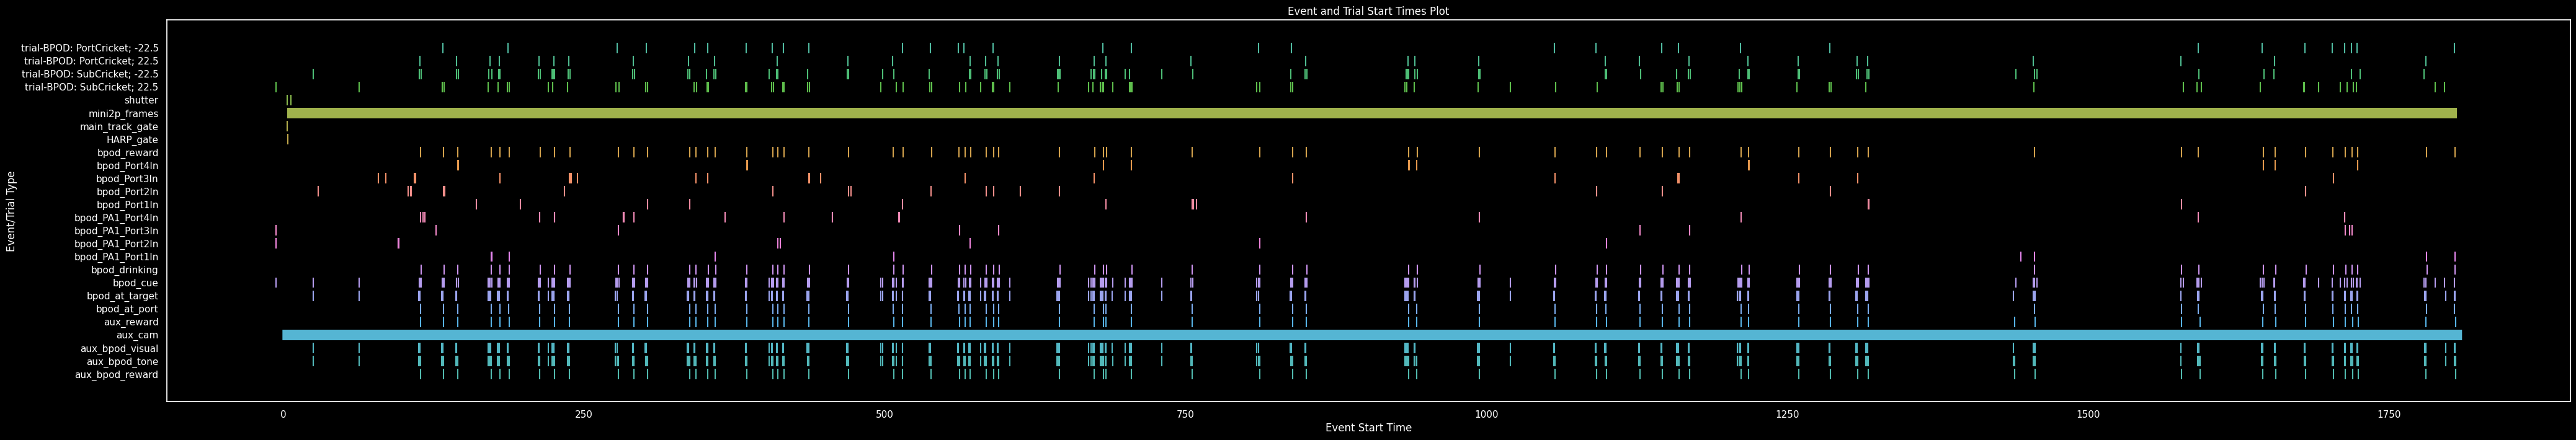

In [17]:
# Fetching data from the event.Event and trial.Trial tables
event_data = event.Event.fetch('event_type', 'event_start_time', as_dict=True)
trial_data = trial.Trial.fetch('trial_id', 'trial_type', 'trial_start_time', as_dict=True)

djh.plot_event_trial_start_times(event_data, trial_data)

### get BPOD object to play around

In [ ]:
from adamacs.paths import get_imaging_root_data_dir, get_experiment_root_data_dir
from adamacs.ingest import bpod
from element_interface.utils import find_full_path

scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0]
bpod_path_relative = (scan.ScanPath & scan_key).fetch("path")[0]

bpod_path_full = list(find_full_path(
        get_experiment_root_data_dir(), bpod_path_relative
        ).glob("*mat"))[0]

print(bpod_path_full)

In [ ]:
bpod_object = bpod.Bpodfile(bpod_path_full)

In [ ]:
bpod_object.session_data["Info"]

In [ ]:
bpod_object.session_data["MousePos"]['PreStimDLC_live'][10]['right_ear']

In [ ]:
bpod_object.session_data['RawEvents']['Trial'][4]['States']

In [ ]:
bpod_object.trial_data[4]['States']

In [ ]:
bpod_object.trial_data[3]['Events']

In [ ]:
trials = bpod_object.trial_data
SoftCode10_events = [(i, trial['Events'].get('SoftCode10')) for i, trial in enumerate(trials) if 'SoftCode10' in trial['Events']] # get all trials that have a BNC1Low event. Returns a list of tuples (trial number, event time)

SoftCode10_events_times = [x[1] for x in SoftCode10_events]

plt.hist(SoftCode10_events_times, edgecolor='black')

plt.title('Histogram of softcode 10 event-to-trial-beginning time')
plt.xlabel('[s]')
plt.ylabel('Frequency')
# plt.xlim([0, 1])
plt.show()

In [ ]:
trials = bpod_object.trial_data
SoftCode15_events = [(i, trial['Events'].get('SoftCode15')) for i, trial in enumerate(trials) if 'SoftCode15' in trial['Events']] # get all trials that have a BNC1Low event. Returns a list of tuples (trial number, event time)

SoftCode15_events_times = [x[1] for x in SoftCode15_events]

plt.hist(SoftCode15_events_times, edgecolor='black')

plt.title('Histogram of softcode 15 event-to-trial-beginning time')
plt.xlabel('[s]')
plt.ylabel('Frequency')
# plt.xlim([0, 100])
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Fetch trial data
trials = bpod_object.trial_data

# Fetch trial start timestamps
bpod_trial = bpod_object.session_data["TrialStartTimestamp"]

WaitForPosTriggerSoftCode_events = [(trial['States'].get('WaitForPosTriggerSoftCode') if trial['States'].get('WaitForPosTriggerSoftCode') is not None else 0) + bpod_trial[i] for i, trial in enumerate(trials) if 'WaitForPosTriggerSoftCode' in trial['States']]
WaitForPosTriggerSoftCode = [event[1] for event in WaitForPosTriggerSoftCode_events]

CueDelayTrialCricket_events = [(trial['States'].get('CueDelayTrialCricket') if trial['States'].get('CueDelayTrialCricket') is not None else 0) + bpod_trial[i] for i, trial in enumerate(trials) if 'CueDelayTrialCricket' in trial['States']]
CueDelayTrialCricket = [event[0] for event in CueDelayTrialCricket_events]

CueDelay_events = [(trial['States'].get('CueDelay') if trial['States'].get('CueDelay') is not None else 0) + bpod_trial[i] for i, trial in enumerate(trials) if 'CueDelay' in trial['States']]
CueDelay  = [event[0] for event in CueDelay_events]

Drinking_events = [(trial['States'].get('Drinking') if trial['States'].get('Drinking') is not None else 0) + bpod_trial[i] for i, trial in enumerate(trials) if 'Drinking' in trial['States']]
DrinkingResponse = [event[0] for event in Drinking_events]


# Fetch all trials that have a BNC1Low event. Returns a list of tuples (trial number, event time)
BNC1Low_events = [(i, trial['Events'].get('BNC1Low')) for i, trial in enumerate(trials) if 'BNC1Low' in trial['Events']]

# Fetch shutter event start times
AUX_shutter = (event.Event & 'scan_id = "' + scansi + '"' & 'event_type LIKE "%shutter%"').fetch("event_start_time")

# Fetch event start times for visual and tone events
aux_vis = (event.Event & 'scan_id = "' + scansi + '"' & 'event_type LIKE "%vis%"').fetch("event_start_time") 
aux_tone = (event.Event & 'scan_id = "' + scansi + '"' & 'event_type LIKE "%tone%"').fetch("event_start_time") 
aux_reward = (event.Event & 'scan_id = "' + scansi + '"' & 'event_type LIKE "%reward%"').fetch("event_start_time") 

# Adjust bpod_trial times

# bpodoffset = (BNC1Low_events[0][1]  + bpod_trial[0]) 

bpodoffset = (WaitForPosTriggerSoftCode[0]) 
aux_offset = aux_vis[0] 

WaitForPosTriggerSoftCode = WaitForPosTriggerSoftCode - bpodoffset + aux_offset
CueDelay = CueDelay - bpodoffset + aux_offset 
CueDelayTrialCricket = CueDelayTrialCricket - bpodoffset + aux_offset
DrinkingResponse = DrinkingResponse - bpodoffset + aux_offset
bpod_trial = bpod_trial - bpodoffset + aux_offset

# # Adjust AUX times
# aux_offset = aux_vis[0] 

# AUX_shutter = AUX_shutter - aux_offset #+  bpod_trial[1]
# aux_vis = aux_vis - aux_offset #+  bpod_trial[1]
# aux_tone    = aux_tone - aux_offset #+  bpod_trial[1]
# aux_reward = aux_reward - aux_offset #+  bpod_trial[1]


# Convert aux_tone, bpod_trial, and aux_vis values from seconds to deciseconds
tone_timestamps = (aux_tone * 100).astype(int)
trial_timestamps = (bpod_trial * 100).astype(int)
vis_timestamps = (aux_vis * 100).astype(int)
reward_timestamps = (aux_reward * 100).astype(int)
WaitForPosTriggerSoftCode_timestamps = (np.array(WaitForPosTriggerSoftCode) * 100).astype(int)
CueDelay_timestamps = (np.array(CueDelay) * 100).astype(int)
CueDelayTrialCricket_timestamps = (np.array(CueDelayTrialCricket) * 100).astype(int)
DrinkingResponse_timestamps = (np.array(DrinkingResponse) * 100).astype(int)

# Create separate timebases for each event type
timebase_tone = np.zeros(int(max(tone_timestamps.max(), trial_timestamps.max(), vis_timestamps.max(), reward_timestamps.max(), WaitForPosTriggerSoftCode_timestamps.max(), CueDelay_timestamps.max()) + 1))
timebase_trial = np.zeros(int(max(tone_timestamps.max(), trial_timestamps.max(), vis_timestamps.max(), reward_timestamps.max(), WaitForPosTriggerSoftCode_timestamps.max(), CueDelay_timestamps.max()) + 1))
timebase_vis = np.zeros(int(max(tone_timestamps.max(), trial_timestamps.max(), vis_timestamps.max(), reward_timestamps.max(), WaitForPosTriggerSoftCode_timestamps.max(), CueDelay_timestamps.max()) + 1))
timebase_reward = np.zeros(int(max(tone_timestamps.max(), trial_timestamps.max(), vis_timestamps.max(), reward_timestamps.max(), WaitForPosTriggerSoftCode_timestamps.max(), CueDelay_timestamps.max()) + 1))
timebase_WaitForPosTriggerSoftCode = np.zeros(int(max(tone_timestamps.max(), trial_timestamps.max(), vis_timestamps.max(), reward_timestamps.max(), WaitForPosTriggerSoftCode_timestamps.max(), CueDelay_timestamps.max()) + 1))
timebase_CueDelay = np.zeros(int(max(tone_timestamps.max(), trial_timestamps.max(), vis_timestamps.max(), reward_timestamps.max(), WaitForPosTriggerSoftCode_timestamps.max(), CueDelay_timestamps.max()) + 1))
timebase_CueDelayTrialCricket = np.zeros(int(max(tone_timestamps.max(), trial_timestamps.max(), vis_timestamps.max(), reward_timestamps.max(), WaitForPosTriggerSoftCode_timestamps.max(), CueDelay_timestamps.max()) + 1))
DrinkResponse = np.zeros(int(max(tone_timestamps.max(), trial_timestamps.max(), vis_timestamps.max(), reward_timestamps.max(), WaitForPosTriggerSoftCode_timestamps.max(), CueDelay_timestamps.max()) + 1))


# Set the timebase samples that correspond to the tone onsets, trial starts, and visual cue onsets to one
# Each event has a duration of 100ms
for timestamp in tone_timestamps:
    timebase_tone[timestamp:timestamp+1] = 2
for timestamp in trial_timestamps:
    timebase_trial[timestamp:timestamp+1] = 3
for timestamp in vis_timestamps:
    timebase_vis[timestamp:timestamp+1] = 1
for timestamp in reward_timestamps:
    timebase_reward[timestamp:timestamp+1] = 4
for timestamp in WaitForPosTriggerSoftCode_timestamps:
    timebase_WaitForPosTriggerSoftCode[timestamp:timestamp+1] = 5
for timestamp in CueDelay_timestamps:
    timebase_CueDelay[timestamp:timestamp+1] = 6
for timestamp in CueDelayTrialCricket_timestamps:
    timebase_CueDelayTrialCricket[timestamp:timestamp+1] = 7  
for timestamp in DrinkingResponse_timestamps:
    DrinkResponse[timestamp:timestamp+1] = 8   

# Set the style to 'dark_background'
plt.style.use('dark_background')

# Create a color palette
colors = sns.color_palette("husl", 8)

# Create a figure with a width that fits the screen
plt.figure(figsize=(50, 10))

# Create tick plots with colors from the palette
linelength = 0.7

plt.eventplot(np.where(timebase_tone == 2)[0], lineoffsets=1, colors=colors[0], linelengths=linelength, label='AUX Tone onsets')
plt.eventplot(np.where(timebase_vis == 1)[0], lineoffsets=2, colors=colors[1], linelengths=linelength, label='AUX Visual cue onsets')
plt.eventplot(np.where(timebase_reward == 4)[0], lineoffsets=3, colors=colors[2], linelengths=linelength, label='AUX Reward onsets')
plt.eventplot(np.where(timebase_trial == 3)[0], lineoffsets=4, colors=colors[3], linelengths=linelength, label='BPOD Trial starts')
plt.eventplot(np.where(timebase_WaitForPosTriggerSoftCode == 5)[0], lineoffsets=5, colors=colors[4], linelengths=linelength, label='WaitForPosTriggerSoftCode')
plt.eventplot(np.where(timebase_CueDelay == 6)[0], lineoffsets=6, colors=colors[5], linelengths=linelength, label='CueDelay')
plt.eventplot(np.where(timebase_CueDelayTrialCricket == 7)[0], lineoffsets=7, colors=colors[6], linelengths=linelength, label='CueDelayTrialCricket') 
plt.eventplot(np.where(DrinkResponse == 8)[0], lineoffsets=8, colors=colors[7], linelengths=linelength, label='DrinkingResponse')

plt.yticks([1, 2, 3, 4, 5, 6, 7, 8], ['AUX Tone onsets', 'AUX Visual cue_triggered', 'AUX Reward onsets', 'BPOD Trial starts', 'WaitForPosTriggerSoftCode', 'CueDelay', 'CueDelayTrialCricket', 'Drinking'])

# Draw vertical lines where timebase_trial == 3

for i in np.where(timebase_trial == 3)[0]:
    plt.axvline(x=i, color='w', linestyle='--', linewidth=0.5, zorder=0)

# Get the y-tick labels
labels = plt.gca().get_yticklabels()

# Find the labels to change
for label in labels:
    if label.get_text() == 'WaitForPosTriggerSoftCode' or label.get_text() == 'AUX Visual cue_triggered':
        label.set_color('red')
        label.set_fontweight('bold')
    if label.get_text() == 'BPOD Trial starts':
        label.set_color('green')
        label.set_fontweight('bold')


plt.legend()
plt.xlim([71000, 81500])
plt.show()

In [ ]:
trial.TrialType()

In [ ]:
def align_timeseries_and_find_non_matching_events(time_series_1, time_series_2):
    # Create event markers for each timeseries
    events_1 = np.zeros(int(np.ceil(max(time_series_1))))
    events_2 = np.zeros(int(np.ceil(max(time_series_2))))

    # Mark the events
    for event in time_series_1:
        events_1[int(event)] = 1
    for event in time_series_2:
        events_2[int(event)] = 1

    # Pad the shorter timeseries with zeros to make them the same length
    if len(events_1) > len(events_2):
        events_2 = np.pad(events_2, (0, len(events_1) - len(events_2)), 'constant')
    elif len(events_2) > len(events_1):
        events_1 = np.pad(events_1, (0, len(events_2) - len(events_1)), 'constant')

    # Perform cross-correlation
    correlation = correlate(events_1, events_2, mode='full')
    lag = np.argmax(correlation) - (len(events_2) - 1)

    # Shift the second series according to the lag
    aligned_series_2 = np.roll(events_2, -lag)[:len(events_1)]

    # Find the indices where events do not match
    non_matching_indices = np.where((events_1 == 1) & (aligned_series_2 == 0))[0]

    # Convert indices back to times
    non_matching_times = time_series_1[np.isin(time_series_1, non_matching_indices)]

    return non_matching_indices, non_matching_times, lag

# Align the two timeseries and find non-matching events
non_matching_indices, non_matching_times, alignment_lag = align_timeseries_and_find_non_matching_events(bpod_trial, aux_tone)

non_matching_indices, non_matching_times, alignment_lag

In [ ]:
aux_tone - aux_tone[0]

In [ ]:
bpod_trial-bpod_trial[1]

In [ ]:
non_matching_times, alignment_lag = align_timeseries_and_find_non_matching_events(bpod_trial, aux_tone)

In [ ]:
import numpy as np
from scipy.signal import correlate

def align_timeseries(series1, series2):
    """
    This function aligns two timeseries data and finds non-matching events.

    :param series1: First timeseries data as a numpy array.
    :param series2: Second timeseries data as a numpy array.
    :return: Indices of non-matching events in series1.
    """

    # Perform cross-correlation
    correlation = correlate(series1, series2, mode='full')
    # Find the lag that maximizes the cross-correlation
    lag = np.argmax(correlation) - (len(series2) - 1)

    # Align the series by shifting series2
    aligned_series2 = np.roll(series2, -lag)

    # Find non-matching events (where one series has an event and the other does not)
    non_matching_events = np.where((series1 != 0) != (aligned_series2[:len(series1)] != 0))[0]

    return non_matching_events, lag, aligned_series2

# Call the alignment function
non_matching_indices, calculated_lag, aligned_series2 = align_timeseries(bpod_trial, aux_tone)

print(f"Non-matching event indices in series1: {non_matching_indices}")
print(f"Lag for alignment: {calculated_lag}")

In [ ]:
aux_tone

In [ ]:
bpod_trial = bpod_object.session_data["TrialStartTimestamp"]
bpod_trial = np.concatenate(([1], bpod_trial))
ones = np.ones_like(bpod_trial)

ones2 = np.ones_like(aligned_series2)

aux_tone = (event.Event & 'scan_id = "' + scansi + '"' & 'event_type LIKE "%vis%"').fetch("event_start_time")
onesfive = np.ones_like(aux_tone) -.5

fig, axs = plt.subplots(2,figsize=(20, 6))
axs[0].scatter(aux_tone, onesfive+0.5)
axs[1].scatter(bpod_trial, ones)
axs[0].scatter(aligned_series2, ones2, c='r')

In [ ]:
from dtw import *
import matplotlib.pyplot as plt

# Create the alignment
alignment = dtw(aux_tone, bpod_trial, keep_internals=True)

# Plot the original time series
plt.figure(figsize=(20, 6))
plt.subplot(3, 1, 1)
plt.plot(aux_tone, label='aux_tone')
plt.plot(bpod_trial, label='bpod_trial')
plt.legend()

# Plot the warping path
plt.subplot(3, 1, 2)
alignment.plot(type="twoway",offset=-2)

# Plot the aligned time series
plt.subplot(3, 1, 3)
plt.plot(aux_tone[alignment.index1], label='aligned aux_tone')
plt.plot(bpod_trial[alignment.index2], label='aligned bpod_trial')
plt.legend()

plt.show()

In [ ]:
alignment.plot()

In [ ]:

def dtw(s, t, window):
    n, m = len(s), len(t)
    w = np.max([window, abs(n-m)])
    dtw_matrix = np.zeros((n+1, m+1))
    
    for i in range(n+1):
        for j in range(m+1):
            dtw_matrix[i, j] = np.inf
    dtw_matrix[0, 0] = 0
    
    for i in range(1, n+1):
        for j in range(np.max([1, i-w]), np.min([m, i+w])+1):
            dtw_matrix[i, j] = 0
    
    for i in range(1, n+1):
        for j in range(np.max([1, i-w]), np.min([m, i+w])+1):
            cost = abs(s[i-1] - t[j-1])
            # take last min from a square box
            last_min = np.min([dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1]])
            dtw_matrix[i, j] = cost + last_min
    return dtw_matrix


In [ ]:
time_series_1 = aux_tone
time_series_2 = bpod_trial
dtw(time_series_1, time_series_2, 100)

In [ ]:
import numpy as np

def dtw_alignment(ts_a, ts_b, d=lambda x, y: abs(x - y)):
    """Computes the Dynamic Time Warping (DTW) alignment between two time series.

    Args:
        ts_a: First time series (list or array).
        ts_b: Second time series (list or array).
        d: Distance function. Defaults to absolute difference.

    Returns:
        path: The optimal path for the alignment.
        DTW: The full DTW matrix.
    """
    # Create cost matrix with infinite values
    DTW = np.full((len(ts_a) + 1, len(ts_b) + 1), np.inf)
    DTW[0, 0] = 0

    # Populate the cost matrix
    for i in range(1, len(ts_a) + 1):
        for j in range(1, len(ts_b) + 1):
            cost = d(ts_a[i-1], ts_b[j-1])
            DTW[i, j] = cost + min(DTW[i-1, j],    # insertion
                                   DTW[i, j-1],    # deletion
                                   DTW[i-1, j-1])  # match

    # Backtrack to find the optimal path
    path = []
    i, j = len(ts_a), len(ts_b)
    while i > 0 and j > 0:
        path.append((i-1, j-1))
        min_index = np.argmin((DTW[i-1, j], DTW[i, j-1], DTW[i-1, j-1]))
        if min_index == 0:
            i -= 1
        elif min_index == 1:
            j -= 1
        else:  # min_index == 2
            i -= 1
            j -= 1

    # Include the start cell in the path
    path.append((0, 0))

    path.reverse()
    return path, DTW

# Example time series data
ts_a = aux_tone
ts_b = bpod_trial

# Get the alignment and DTW matrix
alignment_path, DTW_matrix = dtw_alignment(ts_a, ts_b)

# The alignment path is returned as tuples of aligned indices
alignment_path


In [ ]:
bpod_trial

In [ ]:
aux_tone

## Run image processing jobs


In [ ]:
imaging.Processing.populate(**populate_settings)

### Curation

In [ ]:
imaging.Curation().create1_from_processing_task({'session_id': sessi, 'scan_id': scansi, "paramset_idx": selected_s2pparms_index, "manual_curation": 0})

imaging.MotionCorrection.populate(**populate_settings)

imaging.Segmentation.populate(**populate_settings)

imaging.MaskClassification.populate(**populate_settings)

imaging.Fluorescence.populate(**populate_settings)

imaging.Activity.populate(**populate_settings)

In [ ]:
scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0]
curation_key = (imaging.Curation & scan_key & 'curation_id=1').fetch1('KEY')

## Make Movie

In [ ]:
def make_overview_movies_rspace(curation_key):
    # params_key = (imaging.ProcessingParamSet & 'paramset_idx = "4"').fetch('KEY')
    # reg_tiffs_available = (imaging.ProcessingParamSet & params_key).fetch("params")[0]['reg_tif']
    from scipy.ndimage import mean
    import tifffile
    path = (scan.ScanPath & curation_key).fetch1("path") + ("/suite2p/plane0/reg_tif")

    # path = '/datajoint-data/data/jisooj/RN_OPI-1681_2023-02-15_scan9FGLEFJ3_sess9FGLEFJ3/suite2p_exp9FGLEFJ3/suite2p/plane0/reg_tif'
    # Get a list of all tiff files in the folder
    tiff_files = [os.path.join(path, f) for f in natsorted(os.listdir(path)) if f.endswith('.tif')]

    # print(tiff_files)

    # Load each tiff stack into a list of numpy arrays
    stacks = []
    for f in tiff_files:
        with tifffile.TiffFile(f) as tif:
            # Get the number of pages in the file
            num_pages = len(tif.pages)
            
            # Create a numpy array to store all pages
            stack = np.zeros((num_pages,) + tif.pages[0].shape, dtype=tif.pages[0].dtype)
            
            # Iterate over the pages and store them in the array
            for i, page in enumerate(tif.pages):
                stack[i] = page.asarray()

        stacks.append(stack)

    # Concatenate the stacks into a single numpy array along the z-axis
    volume = np.concatenate(stacks, axis=0)

    # delete registration tiff
    for f in tiff_files:
        os.remove(f) 
    
    ### moving average filter
    # Create a running Z mean projection of the volume

    runav = 30
    # running_z_projection = uniform_filter_mt(volume, size=(runav,xyrunav,xyrunav))
    running_z_projection = sh.rolling_average_filter(volume, runav)

    session_id = curation_key['session_id']
    scan_id = curation_key['scan_id']

    filename = os.path.join(path, 'registered_movie_' + session_id + '_' + scan_id + '_' + str(runav) + '_frame_runningaverage2' + '.mp4')

    fps = 120   # frames per second - 120 default
    p1 = 2       # percentile scaling low - 1 default
    p2 = 99.998  # percentile scaling high - 99.995 default

    rescaled_image_8bit = sh.make_stack_movie(running_z_projection, filename, fps, p1, p2)

    tmpdir = dj.config['custom'].get('suite2p_fast_tmp')[0]


In [ ]:
make_overview_movies_rspace(curation_key)

## Pose estimation

In [ ]:
dj.Diagram(model) + dj.Diagram(equipment)

In [ ]:
aux_setup_typestr = (scan.ScanInfo() & 'scan_id = "' + scansi + '"').fetch("userfunction_info")[0]
selected_DLCmodel = 'Topcam_2bin_with_scope'
print('- - - -')
print('DLC pose estimation:', scansi)

# insert TOP movie into model table
scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0] 
moviepath = str(list(pathlib.Path((scan.ScanPath() & scan_key).fetch("path")[0]).glob("*top*.mp4*"))[0])

key = {'session_id': scan_key["session_id"],
    'recording_id': scan_key["scan_id"], 
    'camera': "mini2p1_top", # Currently 'scanner' due to in equipment tables
    }
model.VideoRecording.insert1(key, skip_duplicates=True)

key.update({'file_path': moviepath,
            'file_id': 0})  #INCREMENT FILE_ID WITH CAM NUMBER?

model.VideoRecording.File.insert1(key, ignore_extra_fields=True, skip_duplicates=True)
model.RecordingInfo.populate()

In [ ]:

model.VideoRecording.File * model.VideoRecording() &  'recording_id = "' + scansi + '"'

In [ ]:
key =  (model.VideoRecording & f'recording_id="{scansi}"').fetch1('KEY')
key.update({'model_name': selected_DLCmodel, 'task_mode': 'trigger'}) 
key      


In [ ]:
# INSERT pose estimation task
model.PoseEstimationTask.insert_estimation_task(key, key["model_name"], analyze_videos_params={'save_as_csv':True, 'dynamic':(True,.5,60)}) # dynamic cropping

In [ ]:
model.PoseEstimationTask() * model.VideoRecording * model.VideoRecording.File()

In [ ]:
model.RecordingInfo()

In [ ]:
# run pose estimation
model.PoseEstimation.populate()

#### make labeled video

In [ ]:
from deeplabcut.utils.make_labeled_video import create_labeled_video
import yaml
from element_interface.utils import find_full_path
from adamacs.paths import get_dlc_root_data_dir


destfolder = model.PoseEstimationTask.infer_output_dir(key)
destfolder

video_path = find_full_path( # Fetch the full video path
    get_dlc_root_data_dir(), ((model.VideoRecording.File & key).fetch1("file_path"))
)

config_paths = sorted( # Of configs in the project path, defer to the datajoint-saved
    list(
        find_full_path(
            get_dlc_root_data_dir(), ((model.Model & key).fetch1("project_path"))
        ).glob("*.y*ml")
    )
)

create_labeled_video( # Pass strings to label the video
    config=str(config_paths[-1]),
    videos=str(video_path),
    destfolder=str(destfolder),
)

# list(list(pathlib.Path((model.VideoRecording.File & key).fetch1("file_path")).parent.glob("device*"))[0].glob("*.y*ml"))

In [ ]:
import glob
mp4_files = glob.glob(f"{destfolder}/*.mp4")

In [ ]:
mp4_files

In [ ]:
(model.PoseEstimation() * session.Session * session.SessionUser * subject.User()).fetch(format = "frame", order_by = "session_datetime")

In [ ]:
# scansi = "scan9FKSMYYS"
scan_key = (model.PoseEstimation & f'recording_id = "{scansi}"').fetch('KEY')[0] 
path = (model.VideoRecording.File & scan_key).fetch("file_path")
path

In [ ]:
(model.PoseEstimation.BodyPartPosition() & scan_key & 'body_part = "head_middle"').fetch("x_pos", "y_pos")

## Cleaning. Use with caution!

In [ ]:
imaging.ProcessingTask()

In [ ]:
# subject.Subject.delete()
# session.Session.delete()
# imaging.Processing.delete()
# imaging.Curation.delete()
# event.Event.delete()
# event.BehaviorRecording.delete()

In [ ]:
key = (session.Session & "session_datetime >= '2023-10-01'").fetch('KEY')
# (session.Session & "session_datetime >= '2023-10-01'").delete()
# (imaging.ProcessingTask & "session_id LIKE 'sess9FKWT2RT%'").delete()
# (imaging.ProcessingTask  & key).delete()
(model.PoseEstimationTask & key).delete()
# (session.Session & "session_id LIKE 'sess9FKWT2RT%'").delete()
# (subject.Subject & "subject = 'ROS-1571'").delete()
# # subject.Subject.delete()
# # session.Session.delete()
# # imaging.Processing.delete()
# # imaging.Curation.delete()
# # event.Event.delete()
# # event.BehaviorRecording.delete()

In [ ]:
session.Session.delete()

In [ ]:
# session.Session.drop()
# scan.Scan.drop()
# imaging.Processing.drop()
# imaging.Curation.drop()